# §1: Setup and data

In [1]:
# Import libraries
from google.cloud import bigquery
from google.cloud import bigquery_storage

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

In [2]:
# Setup Google Cloud credentials
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/your/service-account-key.json"

# Store the service key in the corresponding location in colab files
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/callummagarian/Desktop/Machine-Learning-Final/credentials/acs-dp05-03-analysis-43a26958b715.json"

## Loading data from Bigquery
Here we use the bigquery library to send requests to bq api where our data is stored

In [3]:
load_dotenv()

from google.cloud import bigquery
client = bigquery.Client(project="acs-dp05-03-analysis")

## Creating our Dataframes

In [4]:
# Query the full ACS census tract table:
query = """
SELECT *
FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
"""
# Run query
query_job = client.query(query)

acs_df = query_job.result().to_dataframe(create_bqstorage_client=False)

print("Loaded ACS dataframe with shape:", acs_df.shape)
acs_df.head()

Loaded ACS dataframe with shape: (85395, 245)


,geo_id,aggregate_travel_time_to_work,amerindian_including_hispanic,amerindian_pop,armed_forces,asian_including_hispanic,asian_male_45_54,asian_male_55_64,asian_pop,associates_degree,...,vacant_housing_units,vacant_housing_units_for_rent,vacant_housing_units_for_sale,walked_to_work,white_including_hispanic,white_male_45_54,white_male_55_64,white_pop,worked_at_home,workers_16_and_over
0,1001020200,18595.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,72.0,...,147.0,32.0,0.0,0.0,647.0,89.0,32.0,641.0,10.0,700.0
1,1001020300,47570.0,0.0,0.0,21.0,44.0,0.0,0.0,44.0,243.0,...,113.0,0.0,0.0,34.0,2363.0,143.0,232.0,2363.0,32.0,1959.0
2,1001020400,37660.0,10.0,10.0,10.0,17.0,0.0,0.0,17.0,257.0,...,105.0,23.0,25.0,28.0,3097.0,121.0,258.0,3085.0,45.0,1583.0
3,1001020503,28605.0,0.0,0.0,96.0,18.0,0.0,0.0,18.0,252.0,...,0.0,0.0,0.0,22.0,2397.0,218.0,105.0,2397.0,121.0,1606.0
4,1001020600,23255.0,0.0,0.0,40.0,11.0,0.0,0.0,11.0,145.0,...,134.0,43.0,22.0,6.0,2667.0,193.0,176.0,2551.0,80.0,1212.0


In [5]:
# From here we filter into DP05 and DP03 as needed for analysis

# DP03: Economic features
dp03_cols = [
    "median_income",
    "income_per_capita",
    "poverty",
    "pop_in_labor_force",
    "employed_pop",
    "unemployed_pop",
    "not_in_labor_force",
    "commuters_16_over",
    "aggregate_travel_time_to_work",
    "commute_less_10_mins",
    "commute_5_9_mins",
    "commute_10_14_mins",
    "commute_15_19_mins",
    "commute_20_24_mins",
    "commute_25_29_mins",
    "commute_30_34_mins",
    "commute_35_39_mins",
    "commute_40_44_mins",
    "commute_45_59_mins",
    "commute_60_more_mins",
    "worked_at_home",
    "walked_to_work",
    "no_car",
    "one_car",
    "two_cars",
    "three_cars",
    "four_more_cars",
    "gini_index",
    ]

# DP05: Demographic features
dp05_cols = [
    "total_pop",
    "male_pop",
    "female_pop",
    "male_under_5",
    "male_5_to_9",
    "male_10_to_14",
    "male_15_to_17",
    "male_18_to_19",
    "male_20",
    "male_21",
    "male_22_to_24",
    "male_25_to_29",
    "male_30_to_34",
    "male_35_to_39",
    "male_40_to_44",
    "male_45_to_49",
    "male_50_to_54",
    "male_55_to_59",
    "male_60_to_61",
    "male_62_to_64",
    "male_65_to_66",
    "male_67_to_69",
    "male_70_to_74",
    "male_75_to_79",
    "male_80_to_84",
    "male_85_and_over",
    "female_under_5",
    "female_5_to_9",
    "female_10_to_14",
    "female_15_to_17",
    "female_18_to_19",
    "female_20",
    "female_21",
    "female_22_to_24",
    "female_25_to_29",
    "female_30_to_34",
    "female_35_to_39",
    "female_40_to_44",
    "female_45_to_49",
    "female_50_to_54",
    "female_55_to_59",
    "female_60_to_61",
    "female_62_to_64",
    "female_65_to_66",
    "female_67_to_69",
    "female_70_to_74",
    "female_75_to_79",
    "female_80_to_84",
    "female_85_and_over",
    "white_pop",
    "black_pop",
    "asian_pop",
    "amerindian_pop",
    "other_race_pop",
    "two_or_more_races_pop",
    "hispanic_pop",
    "white_including_hispanic",
    "black_including_hispanic",
    "asian_including_hispanic",
    ]


# §2: Cleaning

In [6]:
# Create target variable 'high_rent_burden' 
acs_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30

acs_df['high_rent_burden'].head()

0     True
1    False
2    False
3    False
4    False
Name: high_rent_burden, dtype: bool

In [7]:
# Handling Sentinel Codes:
sentinel_values = [-666666666, -777777777, -888888888, -999999999]
acs_df.replace(sentinel_values, pd.NA, inplace=True)

In [8]:
# We need to convert some columns to numeric
# We need to cast geo_id and high_rent_burden:
acs_df["geo_id"] = acs_df["geo_id"].astype(str)
acs_df["high_rent_burden"] = acs_df["high_rent_burden"].astype(int)
acs_df["gini_index"] = pd.to_numeric(acs_df["gini_index"], errors='coerce')
acs_df["income_per_capita"] = pd.to_numeric(acs_df["income_per_capita"], errors='coerce')
acs_df["median_age"] = pd.to_numeric(acs_df["median_age"], errors='coerce')
acs_df["median_income"] = pd.to_numeric(acs_df["median_income"], errors='coerce')
acs_df["median_rent"] = pd.to_numeric(acs_df["median_rent"], errors='coerce')
acs_df["median_year_structure_built"] = pd.to_numeric(acs_df["median_year_structure_built"], errors='coerce')
acs_df["owner_occupied_housing_units_lower_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_lower_value_quartile"], errors='coerce')
acs_df["owner_occupied_housing_units_median_value"] = pd.to_numeric(acs_df["owner_occupied_housing_units_median_value"], errors='coerce')
acs_df["owner_occupied_housing_units_upper_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_upper_value_quartile"], errors='coerce')
acs_df["percent_income_spent_on_rent"] = pd.to_numeric(acs_df["percent_income_spent_on_rent"], errors='coerce')
acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"] = pd.to_numeric(acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"], errors='coerce')

Some of these measures are not really useful as pure counts, such as `unemployment_pop`, `vacant_housing_units`, etc. This is because they will end up dominating the model and also make it difficult to generalize across other areas of the country. Rather, we should insert corresponding rates columns:

In [9]:
acs_df["unemployment_rate"] = acs_df["unemployed_pop"] / acs_df["civilian_labor_force"]
acs_df["vacancy_rate"] = acs_df["vacant_housing_units"] / acs_df["occupied_housing_units"]
acs_df["renter_share"] = acs_df["housing_units_renter_occupied"] / acs_df["occupied_housing_units"]

In [10]:
acs_df['percent_bachelors_or_higher'] = (acs_df['bachelors_degree_or_higher_25_64'] / acs_df['pop_25_64']).replace([np.inf, -np.inf], np.nan)
acs_df['children_per_adult'] = (acs_df['children'] / (acs_df['total_pop'] - acs_df['children'])).replace([np.inf, -np.inf], np.nan)
acs_df['non_white_percent'] = ((acs_df['total_pop'] - acs_df['white_pop']) / acs_df['total_pop']).replace([np.inf, -np.inf], np.nan)

# Replace infinite values so the model pipeline can impute them
acs_df.replace([np.inf, -np.inf], np.nan, inplace=True)


§4: Modeling

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import geopandas as gpd
import folium

# 1. Consolidate Features
new_features = ['unemployment_rate', 'vacancy_rate', 'renter_share', 'percent_bachelors_or_higher', 'children_per_adult', 'non_white_percent']
feature_cols = dp03_cols + dp05_cols + new_features

# Remove duplicates
feature_cols = list(dict.fromkeys(feature_cols))

# 2. Unified Data Preparation
model_df = acs_df[['geo_id'] + feature_cols + ['high_rent_burden']].copy()

# Drop rows with no target value
model_df.dropna(subset=['high_rent_burden'], inplace=True)

# Separate features and target
X = model_df.drop(columns=['high_rent_burden', 'geo_id'])
y = model_df['high_rent_burden']

# Identify numeric features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

# Create preprocessing pipelines for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='drop'
    )
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Hyperparameter Tuning
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.1, 0.05],
    'classifier__max_depth': [3, 4]
}

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time= 7.6min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time= 7.6min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time= 7.6min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100; total time= 9.2min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100; total time= 9.2min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=13.8min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=13.9min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=13.9min
[CV] END classifier__learnin

In [13]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[8093 1705]
 [3326 3955]]


In [14]:
# expand on confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 8093
False Positives: 1705
False Negatives: 3326
True Positives: 3955


In [20]:
# table for confusion matrix
import pandas as pd
confusion_df = pd.DataFrame({
    'Predicted Negative': [tn, fn],
    'Predicted Positive': [fp, tp]
}, index=['Actual Negative', 'Actual Positive'])
print("\nConfusion Matrix Table:\n", confusion_df)


Confusion Matrix Table:
                  Predicted Negative  Predicted Positive
Actual Negative                8093                1705
Actual Positive                3326                3955


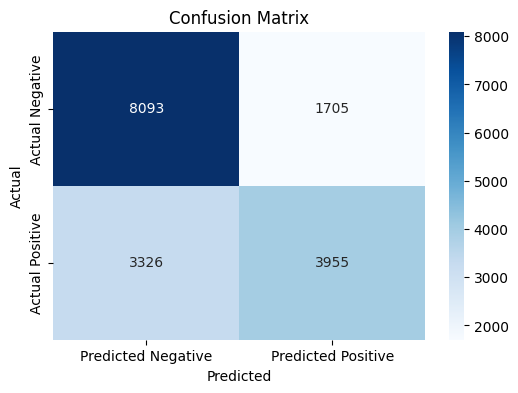

In [23]:
# visualization for confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The confusion matrix displays the counts of true and false positives and negatives. This determines the strengths and weaknesses of model performance such as how many positives were identified as negative and vice versa.

In [16]:
# calculate precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
print(f"Precision: {precision:.4f}")
# calculate recall
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"Recall: {recall:.4f}")

Precision: 0.6988
Recall: 0.5432



Precision and Recall Table:
       Metric     Value
0  Precision  0.698763
1     Recall  0.543195

Precision and Recall Table:
       Metric     Value
0  Precision  0.698763
1     Recall  0.543195


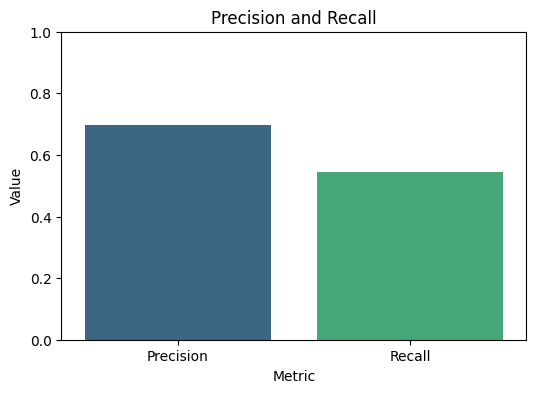

In [27]:
# table for precision
precision_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall'],
    'Value': [precision, recall]
})
print("\nPrecision and Recall Table:\n", precision_df)
# table for recall
recall_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall'],
    'Value': [precision, recall]
})
print("\nPrecision and Recall Table:\n", recall_df)
# visualization for precision
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Value', data=precision_df, palette='viridis', hue ='Metric', dodge=False)
plt.ylim(0, 1)
plt.title('Precision and Recall')
plt.show()

This comparison determines precision to score at 0.70 while recall is 0.54. Precision demonstrates how many predicted positives are True Positives and Recall shows how many positives were ultimately.

In [17]:
# find false positive rate
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
print(f"False Positive Rate: {false_positive_rate:.4f}")
# find true positive rate
true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"True Positive Rate: {true_positive_rate:.4f}")

False Positive Rate: 0.1740
True Positive Rate: 0.5432



TPR and FPR Table:
                 Metric     Value
0  False Positive Rate  0.174015
1   True Positive Rate  0.543195


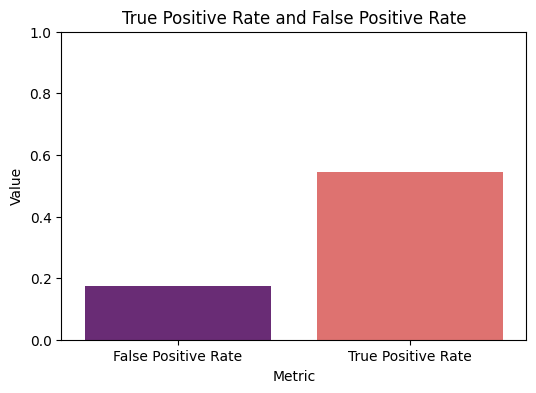

In [28]:
# table for false positive and true positive rates
tpr_fpr_df = pd.DataFrame({
    'Metric': ['False Positive Rate', 'True Positive Rate'],
    'Value': [false_positive_rate, true_positive_rate]
})
print("\nTPR and FPR Table:\n", tpr_fpr_df)
# visualization for false positive and true positive rates
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Value', data=tpr_fpr_df, palette='magma', hue='Metric', dodge=False)
plt.ylim(0, 1)
plt.title('True Positive Rate and False Positive Rate')
plt.show()

These computations demonstrate an FPR of 0.17 and TPR of 0.54. These are important for measuring how often models misclassify negatives as positions and how many observations are correctly classified as positive.

AUC: 0.7676


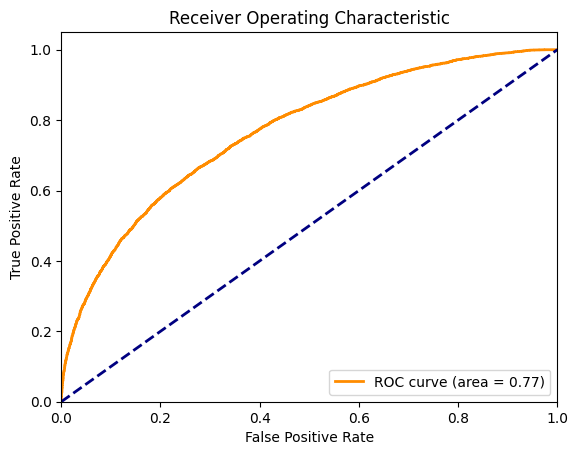

In [18]:
# constructing plot to find ROC curve and AUC
from sklearn.metrics import roc_curve, auc
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The Receiver Operating Characteristic curve is ploted and the Area Under the Curve scores at 0.77. This is decently strong performance, showing a good, but not great ability to predict each class.

§5: Model Interpretation with SHAP

In [29]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.2/558.2 kB 3.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 6.1 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 MB 7.1 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/6 [tqdm]  WARNING: The script tqdm is installed in '/Library/Frameworks/Python.framework/Versions/3.13/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]
Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 17025/17079 [02:08<00:00]        

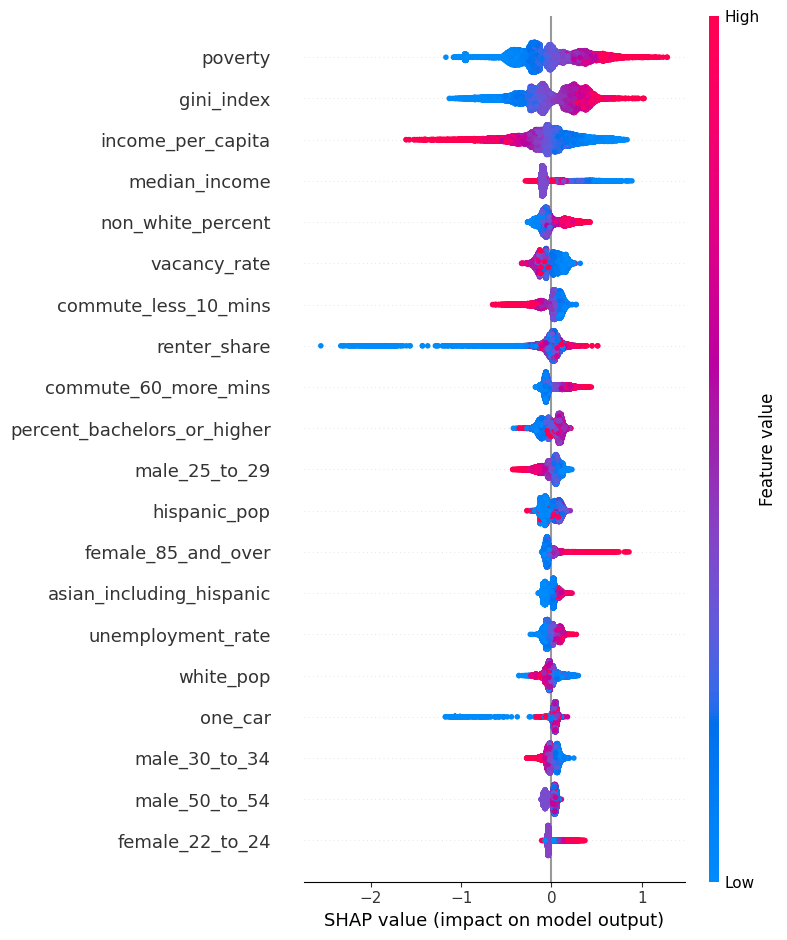

In [30]:
import shap

# Transform train and test data with the fitted preprocessor
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# SHAP works best with DataFrames for plotting
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numeric_features)

# Create SHAP explainer for the trained classifier
explainer = shap.Explainer(
    best_model.named_steps['classifier'],
    X_train_transformed,
    feature_names=numeric_features,
)

# Disable additivity check to avoid logit/probability mismatches
shap_values = explainer(X_test_transformed, check_additivity=False)

# Summary plot
shap.summary_plot(shap_values, X_test_transformed_df, feature_names=numeric_features)


§6: Error Analysis Map

In [31]:
from pathlib import Path
import urllib.request

# Predict on all rows for full-map coverage
features_all = model_df.drop(columns=['high_rent_burden', 'geo_id'])
all_preds = best_model.predict(features_all)

all_df = model_df[['geo_id', 'high_rent_burden']].copy()
all_df['high_rent_burden_pred'] = all_preds
all_df['prediction_error'] = all_df['high_rent_burden_pred'] - all_df['high_rent_burden']
all_df['geo_id'] = all_df['geo_id'].astype(str).str.zfill(11)

# Ensure the Rhode Island tract shapefile is available (download if missing)
data_dir = Path('notebooks/data')
data_dir.mkdir(parents=True, exist_ok=True)
shapefile_zip = data_dir / 'tl_2018_44_tract.zip'
if not shapefile_zip.exists():
    shapefile_url = 'https://www2.census.gov/geo/tiger/TIGER2018/TRACT/tl_2018_44_tract.zip'
    urllib.request.urlretrieve(shapefile_url, shapefile_zip)

# Load shapefile directly from the zip and filter to Rhode Island
ri_tracts = gpd.read_file(f"zip://{shapefile_zip}")
ri_tracts = ri_tracts[ri_tracts.STATEFP == '44']
ri_tracts['GEOID'] = ri_tracts['GEOID'].astype(str).str.zfill(11)

# Merge with prediction errors for all tracts
map_gdf = ri_tracts.merge(all_df, left_on='GEOID', right_on='geo_id', how='left')

# Create map
m = folium.Map(location=[41.7, -71.5], zoom_start=10)

folium.Choropleth(
    geo_data=map_gdf.to_json(),
    name='Prediction Error',
    data=map_gdf,
    columns=['GEOID', 'prediction_error'],
    key_on='feature.properties.GEOID',
    fill_color='RdBu',
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name='Prediction Error (1: False Positive, -1: False Negative)',
    ).add_to(m)

folium.LayerControl().add_to(m)
m


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1032)>